<h2>Bateman_May_calcs_forecast</h2>

Derivative of Bateman_May_calcs changed to produce forecasts through 2100.


##### Import dependencies
LmFit (https://lmfit.github.io/lmfit-py/) "provides a high-level interface to non-linear optimization and curve fitting problems".

In [1]:
from scipy.integrate import odeint
from pylab import *
from lmfit import *
%matplotlib inline

# This next line controls whether bare variable names print in the output box
# As suggested in https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

import pandas as pd
#from IPython.display import display, HTML

##### The next cell contains key switches
* Identify which site to process
* Choose whether to adjust the inventories according to PCB anomolies. If selected `adjust_inventories` is `True` then computations are performed using adjusted inventories ${{C}_{i,\,adj}}$.
* Choose whether to include estimates of the std. deviations $\sigma_i$ of inventories in the objective function. The objective function returns an array of length $N$ for each observation $data_i$ and associated modeled result $model_i$ and is calculated as $$\frac{{{\left( mode{{l}_{i}}-dat{{a}_{i}} \right)}^{2}}}{\sigma _{i}^{2}}$$ If `use_eps` is `False`, $\sigma = 1$.

In [2]:
# Pick one of the two sites
site = 'Site 3C'
#site = 'Site 6C'

# Adjust using PCBs?
adjust_inventories=True

# Use std. deviations in chi-square calculation?
use_eps=True

# These strings are used to build filenames for the output figures and set y-axis limits
itext = '_'
if adjust_inventories:
    itext = "_adj_"
etext = '_'
if use_eps:
    etext = "_eps_"
yl = [0., 1.5]
if site=='Site 6C':
    yl = [0., 3.5]

##### These data are from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 'Inventories for C.Sherwood 12-16-2016.xlsx'
Columns represent: time (decimal years), p,p'-DDE, p,p'-DDMU, p,p'-DDNU, PCB 118, PCB 153, PBC 138, PCB28, and PCB70 ($\mu mol \: cm^{-2}$)

In [3]:
# Load data from the selected site.
# This data comes from the spreadsheet "Inventories for C. Sherwood 12-16-2016.xlsx" which was modified
# and resent to CRS on 4/7/2016. The modifications added inventories of the congeners PCB28 and PBC70.
cols=["Year","DDE","DDMU","DDNU","PCB118","PCB153","PCB138","PCB28","PCB70"]
A=np.array([\
    [1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076,0.0025,0.0077],\
    [1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064,0.0017,0.0057],\
    [2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050,0.0012,0.0038],\
    [2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085,0.0030,0.0057],\
    [2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079,0.0033,0.0061]])
#C3 = pd.DataFrame(A,columns=cols)

B=np.array([\
    [1992.52,3.07,0.67,0.026,0.0182,0.0119,0.0152,0.0084,0.0216],\
    [2003.58,2.75,0.87,0.072,0.0177,0.0122,0.0158,0.0106,0.0230],\
    [2009.23,2.37,0.75,0.095,0.0172,0.0095,0.0134,0.0112,0.0271],\
    [2010.31,1.16,0.43,0.046,0.0079,0.0054,0.0065,0.0032,0.0104]])
#C6 = pd.DataFrame(B,columns=cols)

# Load data for the selected site
if site == 'Site 3C':  
    t = A[:,0]
    DDE=A[:,1]
    DDMU=A[:,2]
    DDNU=A[:,3]
    PCB118=A[:,4]
    PCB153=A[:,5]
    PCB138=A[:,6]
    PCB28=A[:,7]
    PCB70=A[:,8]
    print("Data from {0} with shape {1}".format(site,A.shape))
    print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in A]))

if site == 'Site 6C':  
    t = B[:,0]
    DDE=B[:,1]
    DDMU=B[:,2]
    DDNU=B[:,3]
    PCB118=B[:,4]
    PCB153=B[:,5]
    PCB138=B[:,6]
    PCB28=B[:,7]
    PCB70=B[:,8]
    print("Data from {0} with shape {1}".format(site,B.shape))
    print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in B]))

Data from Site 3C with shape (5L, 9L)
1981.2700  1.3400  0.0700  0.0040  0.0081  0.0062  0.0076  0.0025  0.0077  
1992.5100  0.7100  0.2500  0.0120  0.0066  0.0049  0.0064  0.0017  0.0057  
2003.5800  0.3900  0.3200  0.0360  0.0050  0.0037  0.0050  0.0012  0.0038  
2009.2300  0.3800  0.5200  0.0690  0.0076  0.0076  0.0085  0.0030  0.0057  
2010.3100  0.4100  0.5200  0.0850  0.0075  0.0072  0.0079  0.0033  0.0061  


##### Make some plots of inventory over time

In [4]:
# calculate adjustment according to mean of all PCBs inventory
adj_PCB118 = mean(PCB118)/PCB118
adj_PCB153 = mean(PCB153)/PCB153
adj_PCB138 = mean(PCB138)/PCB138
adj_PCB28 = mean(PCB28)/PCB28
adj_PCB70 = mean(PCB70)/PCB70

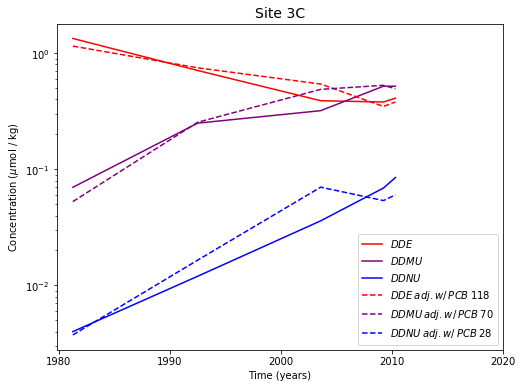

In [5]:
InteractiveShell.ast_node_interactivity = "none"
# calculate first-order RDC for 
fig = plt.figure(figsize=(8,6))
plt.semilogy(t,DDE,label='$DDE$',color='red')
plt.semilogy(t,DDMU,label='$DDMU$',color='purple')
plt.semilogy(t,DDNU,label='$DDNU$',color='blue')

plt.semilogy(t,DDE*adj_PCB118,label='$DDE \:adj. w/ \:PCB \: 118$',color='red',linestyle='dashed')
plt.semilogy(t,DDMU*adj_PCB70,label='$DDMU \:adj. w/  \: PCB \: 70$',color='purple',linestyle='dashed')
plt.semilogy(t,DDNU*adj_PCB28,label='$DDNU \:adj. w/  \: PCB \: 28$',color='blue',linestyle='dashed')

plt.xlabel('Time (years)')
plt.ylabel('Concentration ($\mu$mol / kg)')
if site=='Site 3C':
    plt.legend(loc='lower right')
if site=='Site 6C':
    plt.legend(loc='lower left')
plt.xticks(np.arange(1980,2020+1,10))
ttle = site
plt.title(ttle,fontsize=14)
figname = site+"inventory_time_series_rev.png"
plt.savefig(figname,bbox_inches='tight')

##### Define the model
This is a simpler version with no global decay rate, and no fourth-generation product. It is a coupled set of ordinary differential equations that, in the model, are integrated with the `scipy.odeint` function.

In [6]:
# Version of ODE with three-generation transformation and only three transfer terms
def dcdt3(c, t, k):
    dfdt = np.zeros(3)
    dfdt[0] = c[0]* -k[0]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0]
    dfdt[2] = c[2]* -k[2] + c[1]*k[1]
    return dfdt

##### Define the objective functions to minimize
These functions return the quantity that lmfit will try to minimize. They are returned as vectors of length $N$, the number of data points (and corresponding model estimates). The RMS of this vector is the chi-square goodness of fit.

In [7]:
# Objective function to minimize, fit through origin, estimate decay rate
def residual(params, t, data, eps_data):
    C0 = data[0]
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)**2/eps_data**2

# Objective function to minimize, estimate origin and decay rate
def residual2(params, t, data, eps_data):
    C0 = params['init_conc']
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)**2/eps_data**2

# Objective function using ODE for three-generation transformation 
def residual3(params, t, data, eps_data):
    # Data is passed as a vector
    # Index on length of time array to find intitial concentrations
    nt = t.size
    k = np.array((params['k1'],params['k2'],params['k3']))
    C0 = np.array((data[0],data[nt],data[2*nt]))
    C = odeint(dcdt3,C0,t, args = (k,))
    model = np.concatenate((C[:,0],C[:,1],C[:,2]))
    return (data-model)**2/eps_data**2
    

In [8]:
# guess at std. error in measurements per conv. with R.E.
stde_DDE  = 0.05          #RE suggests 0.05
stde_DDMU = 0.1          #RE suggested 0.1
stde_DDNU = 0.1          #RE suggested 0.1
stde_PCB  = 0.2          # std. error of measurements is around 0.2
eps_DDE  = stde_DDE*DDE  
eps_DDMU = stde_DDMU*DDMU
eps_DDNU = stde_DDNU*DDNU
eps_PCB118 = stde_PCB*PCB118
eps_PCB28 = stde_PCB*PCB28
eps_PCB70 = stde_PCB*PCB70
# note to self: I think I should just use the std. error, because the PCB adjustments are normalized.

#### Fit the multi-step decay model, with or without PCB adjustment

In [9]:
# Put data for all compounds in a single vector
nt = t.size
data = np.concatenate((DDE,DDMU,DDNU))
if(adjust_inventories):
    data = np.concatenate((DDE*adj_PCB118,DDMU*adj_PCB70,DDNU*adj_PCB28))

eps_data = np.ones_like(data)
data_ebar = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))
if(use_eps):
    eps_data = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))
    if(adjust_inventories):
        eps_data = np.concatenate((np.sqrt(eps_DDE**2+stde_PCB**2),\
                                   np.sqrt(eps_DDMU**2+stde_PCB**2),\
                                   np.sqrt(eps_DDNU**2+stde_PCB**2)))
        data_ebar = np.concatenate((np.sqrt(eps_DDE**2+stde_PCB**2),\
                                   np.sqrt(eps_DDMU**2+stde_PCB**2),\
                                   np.sqrt(eps_DDNU**2+stde_PCB**2)))

print('data')
print(data)
print('eps_data')
print(eps_data)

data
[ 1.15140741  0.74872727  0.54288     0.348       0.38048     0.05272727
  0.25438596  0.48842105  0.52912281  0.49442623  0.003744    0.01651765
  0.0702      0.05382     0.06027273]
eps_data
[ 0.21092416  0.20312619  0.20094838  0.20090047  0.20104788  0.20012246
  0.20155644  0.20254382  0.20664946  0.20664946  0.2000004   0.2000036
  0.2000324   0.20011899  0.20018054]


In [10]:
# fit the multistep model                                 
params = Parameters()
params.add('k1',value = 0.4, min =0., max = 0.6)
params.add('k2',value = 0.4, min =0., max = 0.6)
params.add('k3',value = 0.4, min =0., max = 2.0)

# Test the ODE solver
k = np.array((params['k1'],params['k2'],params['k3']))
C0 = np.array((data[0],data[nt],data[2*nt]))
C = odeint(dcdt3,C0,t, args = (k,))
model = np.concatenate((C[:,0],C[:,1],C[:,2]))

# Test the objective function outside
res = residual3(params, t, data, np.ones_like(data))
print("residual3 shape:",shape(res))
print("RMS residuals: {:}".format( np.sqrt(np.mean(res**2))))

# Optimize the parameters using least-squares fit
out = minimize(residual3, params, method='leastsq', args=(t,data,eps_data))

# Get the fitted rates
kf = np.zeros((3,))
kf[0]=out.params['k1'].value
kf[1]=out.params['k2'].value
kf[2]=out.params['k3'].value
ke = np.zeros((3,))
ke[0] = out.params['k1'].stderr
ke[1] = out.params['k2'].stderr
ke[2] = out.params['k3'].stderr

# Get fit metrics
chis = out.chisqr
chir = out.redchi

# Run the ODE solver with best-fit results
tm = linspace(t[0],2100.,100)
C0 = np.array((data[0],data[nt],data[2*nt]))
Cm = odeint(dcdt3,C0,tm, args = (kf,))

('residual3 shape:', (15L,))
RMS residuals: 0.201919859981


In [11]:
# find date when DDMU > DDE
def indices(a, b):
    return min([i for (i, val) in enumerate(a) if a[i]>=b[i]])

if site=='Site 3C':
    i=indices(Cm[:,1],Cm[:,0])
    print("{0} {1} {2} {3}\n{4} {5} {6} {7})".format(i,tm[i],Cm[i,0],Cm[i,1],i-1,tm[i-1],Cm[i-1,0],Cm[i-1,1]))

    b = (Cm[i,0]-Cm[i-1,0])/(tm[i]-tm[i-1])
    b2 = (Cm[i,1]-Cm[i-1,1])/(tm[i]-tm[i-1])
    # calculate the intersection of the two lines
    xs = (Cm[i-1,0] - Cm[i-1,1])/(b2-b)
    print(xs+tm[i-1])

22 2007.65444444 0.445869561902 0.463597197173
21 2006.45515152 0.465517553455 0.462135534556)
2006.64729258



Fit to DDE, DDMU, and DDNU
 Site 3C
  Inventories adjusted by selected PCB inventories
  Using estimates of std. errors
[[Fit Statistics]]
    # function evals   = 72
    # data points      = 15
    # variables        = 3
    chi-square         = 0.086
    reduced chi-square = 0.007
    Akaike info crit   = -71.376
    Bayesian info crit = -69.252
[[Variables]]
    k1:   0.03595731 +/- 0.001590 (4.42%) (init= 0.4)
    k2:   0.03275619 +/- 0.003746 (11.44%) (init= 0.4)
    k3:   0.25116682 +/- 0.472028 (187.93%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k1, k2)                    =  0.550 
5
(5L,)
(5L,)
(15L,)


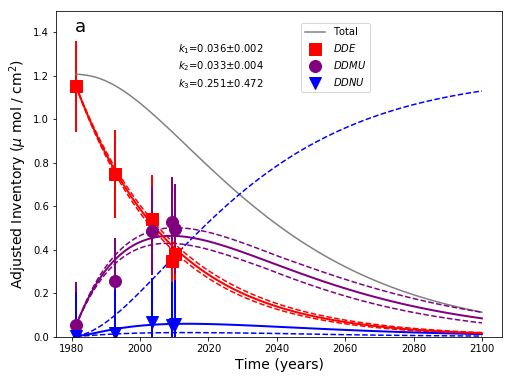

In [12]:
# now run it for all of the cases with +/- uncertainty
kmult = np.array((0.,1.,-1.))
kep = np.zeros((27,3))
Cc = np.zeros_like(Cm)
Cmax = np.zeros_like(Cm)
Cmin = np.zeros_like(Cm)
lt=len(tm)
C1 = np.zeros((27,lt))
C2 = np.zeros((27,lt))
C3 = np.zeros((27,lt))
n =0
for k in np.arange(3):
    for j in np.arange(3):
        for i in np.arange(3):
            kep[n][0]=max(0.,kf[0]+ke[0]*kmult[k])
            kep[n][1]=max(0.,kf[1]+ke[1]*kmult[i])
            kep[n][2]=max(0.,kf[2]+ke[2]*kmult[j])
            C0 = np.array((data[0],data[nt],data[2*nt]))
            Cc = odeint(dcdt3,C0,tm, args = (kep[n,:],))
            C1[n,:] = Cc[:,0]
            C2[n,:] = Cc[:,1]
            C3[n,:] = Cc[:,2]
            n=n+1

Cmax[:,0] = np.amax(C1,axis=0)
Cmin[:,0] = np.amin(C1,axis=0)
Cmax[:,1] = np.amax(C2,axis=0)
Cmin[:,1] = np.amin(C2,axis=0)
Cmax[:,2] = np.amax(C3,axis=0)
Cmin[:,2] = np.amin(C3,axis=0)

print('\nFit to DDE, DDMU, and DDNU')
print(" {}".format(site))
if(adjust_inventories):
    print("  Inventories adjusted by selected PCB inventories")
if(use_eps):
    print("  Using estimates of std. errors")
report_fit(out)

print(nt)
print(shape(t))
print(shape(data[0:nt]))
print(shape(eps_data))


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(tm,Cm[:,0]+Cm[:,1]+Cm[:,2],'-',color='gray',label="Total")
plt.plot(tm,Cmax[:,2],'--',color='blue') #DDNU error bars disabled
plt.plot(tm,Cmin[:,2],'--',color='blue')
plt.plot(tm,Cmax[:,1],'--',color='purple')
plt.plot(tm,Cmin[:,1],'--',color='purple')
plt.plot(tm,Cmax[:,0],'--',color='red')
plt.plot(tm,Cmin[:,0],'--',color='red')
plt.plot(tm,Cm[:,2],'-', color='blue',linewidth=2)
plt.plot(tm,Cm[:,1],'-', color='purple',linewidth=2)
plt.plot(tm,Cm[:,0],'-', color='red',linewidth=2)
plt.plot(t,data[0:nt],'s',color='red',markersize=12,linestyle='None',label='$DDE$')
plt.plot(t,data[nt:2*nt],'o',color='purple',markersize=12,linestyle='None',label='$DDMU$')
plt.plot(t,data[2*nt:3*nt],'v',color='blue',markersize=12,linestyle='None',label='$DDNU$')
plt.errorbar(t,data[0:nt], yerr=data_ebar[0:nt],color='red',elinewidth=2,linestyle='None')
plt.errorbar(t,data[nt:2*nt], yerr=data_ebar[nt:2*nt],color='purple',elinewidth=2,linestyle='None')
plt.errorbar(t,data[2*nt:3*nt], yerr=data_ebar[2*nt:3*nt],color='blue',elinewidth=2,linestyle='None')
plt.xticks(np.arange(1980,2100+1,20))
plt.xlabel(r'Time (years)', fontsize=14)

ax.set_ylim(yl)
plt.ylabel(r'Adjusted Inventory ($\mu$ mol / cm$^2$)',fontsize=14)
ts0 = r"$\chi _{\upsilon }^{2}$"+"={0:.3f}".format(chir)
ts1=  r"$k_1$"+"={0:.3f}".format(kf[0])+r"$\pm${0:.3f}".format(ke[0])
ts2=  r"$k_2$"+"={0:.3f}".format(kf[1])+r"$\pm${0:.3f}".format(ke[1])
ts3=  r"$k_3$"+"={0:.3f}".format(kf[2])+r"$\pm${0:.3f}".format(ke[2])
#ax.text(2025.,.35,ts0)

if site=='Site 3C':
    plt.legend(loc=(.55,.75))
    ax.text(1981,1.4,"a",fontsize=18)
    ax.text(2011.,1.31,ts1)
    ax.text(2011.,1.23,ts2)
    ax.text(2011.,1.15,ts3)
if site=='Site 6C':
    plt.legend(loc=(.8,.75))
    ax.text(1981,1.4*3.5/1.5,"b",fontsize=18)               
    ax.text(2075.,2.4,ts1)
    ax.text(2075.,2.22,ts2)
    ax.text(2075.,2.08,ts3)
    
ttle = site
if(adjust_inventories==True):
    ttle = ttle+r" (adj.)"
if(use_eps==True):
    ttle = ttle+r" with eps"
#plt.title(ttle,fontsize=14)
figname = site+itext+etext+"DDE_DDMU_DDNU_forcst.png"
plt.savefig(figname, bbox_inches='tight')

In [13]:
##### Clean version with no error bars

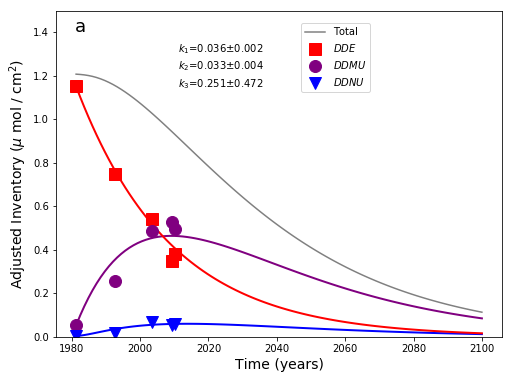

In [14]:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(tm,Cm[:,0]+Cm[:,1]+Cm[:,2],'-',color='gray',label="Total")
#plt.plot(tm,Cmax[:,2],'--',color='blue') #DDNU error bars disabled
#plt.plot(tm,Cmin[:,2],'--',color='blue')
#plt.plot(tm,Cmax[:,1],'--',color='purple')
#plt.plot(tm,Cmin[:,1],'--',color='purple')
#plt.plot(tm,Cmax[:,0],'--',color='red')
#plt.plot(tm,Cmin[:,0],'--',color='red')
plt.plot(tm,Cm[:,2],'-', color='blue',linewidth=2)
plt.plot(tm,Cm[:,1],'-', color='purple',linewidth=2)
plt.plot(tm,Cm[:,0],'-', color='red',linewidth=2)
plt.plot(t,data[0:nt],'s',color='red',markersize=12,linestyle='None',label='$DDE$')
plt.plot(t,data[nt:2*nt],'o',color='purple',markersize=12,linestyle='None',label='$DDMU$')
plt.plot(t,data[2*nt:3*nt],'v',color='blue',markersize=12,linestyle='None',label='$DDNU$')
#plt.errorbar(t,data[0:nt], yerr=data_ebar[0:nt],color='red',elinewidth=2,linestyle='None')
#plt.errorbar(t,data[nt:2*nt], yerr=data_ebar[nt:2*nt],color='purple',elinewidth=2,linestyle='None')
#plt.errorbar(t,data[2*nt:3*nt], yerr=data_ebar[2*nt:3*nt],color='blue',elinewidth=2,linestyle='None')
plt.xticks(np.arange(1980,2100+1,20))
plt.xlabel(r'Time (years)', fontsize=14)

ax.set_ylim(yl)
plt.ylabel(r'Adjusted Inventory ($\mu$ mol / cm$^2$)',fontsize=14)
ts0 = r"$\chi _{\upsilon }^{2}$"+"={0:.3f}".format(chir)
ts1=  r"$k_1$"+"={0:.3f}".format(kf[0])+r"$\pm${0:.3f}".format(ke[0])
ts2=  r"$k_2$"+"={0:.3f}".format(kf[1])+r"$\pm${0:.3f}".format(ke[1])
ts3=  r"$k_3$"+"={0:.3f}".format(kf[2])+r"$\pm${0:.3f}".format(ke[2])
#ax.text(2025.,.35,ts0)

if site=='Site 3C':
    plt.legend(loc=(.55,.75))
    ax.text(1981,1.4,"a",fontsize=18)
    ax.text(2011.,1.31,ts1)
    ax.text(2011.,1.23,ts2)
    ax.text(2011.,1.15,ts3)
if site=='Site 6C':
    plt.legend(loc=(.8,.75))
    ax.text(1981,1.4*3.5/1.5,"b",fontsize=18)               
    ax.text(2075.,2.4,ts1)
    ax.text(2075.,2.22,ts2)
    ax.text(2075.,2.08,ts3)
    
ttle = site
if(adjust_inventories==True):
    ttle = ttle+r" (adj.)"
if(use_eps==True):
    ttle = ttle+r" with eps"
#plt.title(ttle,fontsize=14)
figname = site+itext+etext+"DDE_DDMU_DDNU_forcst_no_error_bars.png"
plt.savefig(figname, bbox_inches='tight')